## [Time Series Forecasting Tutorial - Part 1](http://www.kaggle.com/code/youknowjp/time-series-forcasting-using-xgboost)
## Time Series Forecasting Tutorial - Part 2

This notebook continues the tutorial on forecasting energy consumption using machine learning techniques. We’ll cover data preparation, model training, cross-validation, and future predictions, accompanied by detailed explanations of each step.

---

## Time Series Forecasting for Energy Consumption

This notebook demonstrates an end-to-end approach to forecasting energy consumption using machine learning techniques. It covers key steps such as data preparation, model training, cross-validation, and future prediction, aiming to provide a structured workflow that can be adapted to various time series forecasting applications.

---

## Goal of the Project

The goal is to build a predictive model for energy consumption, focusing on PJME (Pennsylvania, Jersey, Maryland, and Eastern) data, using time series forecasting. By analyzing past energy consumption patterns, the model can predict future usage and offer insights into energy demand trends, potentially aiding grid management and resource planning.

---

## Notebook Outline

### 1. **Setup**
   - **Import Libraries**: Required libraries are imported for data manipulation, visualization, model building, and evaluation.
   - **Libraries**:
     - **Data Manipulation**: `pandas` and `numpy`
     - **Visualization**: `matplotlib` and `seaborn`
     - **Machine Learning**: `xgboost` for gradient-boosted regression models
     - **Metrics**: `mean_squared_error` for model accuracy evaluation

### 2. **Data Preparation and Exploration**
   - **Data Loading and Initial Plotting**: Load the dataset, set up the date as the index, and perform an initial plot to visualize trends and patterns.
   - **Outlier Analysis**: Identify and remove outliers to improve model accuracy by focusing on typical consumption levels.
   - **Train/Test Split**: Split data at a specific date to create training and testing sets, preparing the data for model evaluation.

### 3. **Model Training and Validation**
   - **Time Series Cross-Validation**: Use `TimeSeriesSplit` for a cross-validation approach tailored to time series data, which trains and tests the model sequentially on historical data.
   - **Feature Engineering**: Generate time-based features (e.g., month, day, hour) and lagged features that capture temporal patterns and seasonal trends.
   - **Hyperparameter Tuning with Optuna**: Optimize model parameters for better accuracy, utilizing cross-validation to ensure the model generalizes well across different segments of the dataset.

### 4. **Forecasting Future Values**
   - **Model Retraining**: Retrain the model on the entire dataset for final predictions, maximizing the use of historical data.
   - **Future Data Preparation**: Create future date ranges, apply feature engineering, and use lag features to prepare data for predictions.
   - **Prediction and Visualization**: Generate predictions and visualize future energy consumption trends, helping to provide a clear picture of anticipated demand.

### 5. **Model Saving and Reloading**
   - Save and reload the model for future use without retraining, facilitating efficient deployment and reuse.

---

## Code Explanation

The code begins with **library imports** for essential functions, followed by **data loading** and **preparation** to ensure time-based indexing. **Outliers** are identified and removed to clean the dataset, followed by a **train/test split** to create distinct training and validation sets.

A **cross-validation strategy** suited to time series data is implemented, allowing the model to learn sequential patterns without data leakage. The code includes **feature engineering** to enrich the dataset with additional time-based features and **lagged values** to capture seasonality.

An **Optuna objective function** is set up for hyperparameter tuning, running cross-validation to refine model parameters. After finding optimal parameters, the model is retrained on the full dataset, and **future predictions** are made, visualized, and annotated to reveal trends in future energy demand.

Finally, **model saving and reloading** functionality is incorporated for efficient reuse.

---

This structure provides a comprehensive guide for using machine learning to forecast energy consumption, with a reproducible pipeline applicable to similar time series datasets.


In [1]:
# Import libraries
import numpy as np               # For numerical operations and linear algebra, such as array and matrix manipulations
import pandas as pd              # For data processing, including data manipulation and reading/writing CSV files (e.g., pd.read_csv)
import optuna                    # For automated hyperparameter tuning, which optimizes model parameters to improve accuracy
import logging                   # For controlling and managing log outputs, especially useful in suppressing or capturing log messages
import seaborn as sns            # For data visualization, particularly for creating aesthetically pleasing statistical graphics
import matplotlib.pyplot as plt  # For general-purpose plotting, allows for custom charts and visualizations

import xgboost as xgb            # XGBoost library, used for efficient gradient boosting, which is popular for structured/tabular data
from xgboost import plot_importance, plot_tree  # Additional XGBoost functions for visualizing feature importance and decision trees
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Performance metrics for model evaluation, particularly useful for regression tasks

# Set color palette and style for visualizations
color_pal = sns.color_palette()  # Define a color palette for consistent styling across plots
plt.style.use('fivethirtyeight') # Set plot style to 'fivethirtyeight' for a clean and professional look

# Suppress Optuna trial output
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)


In [3]:
# Load head data
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
# Load tail data
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


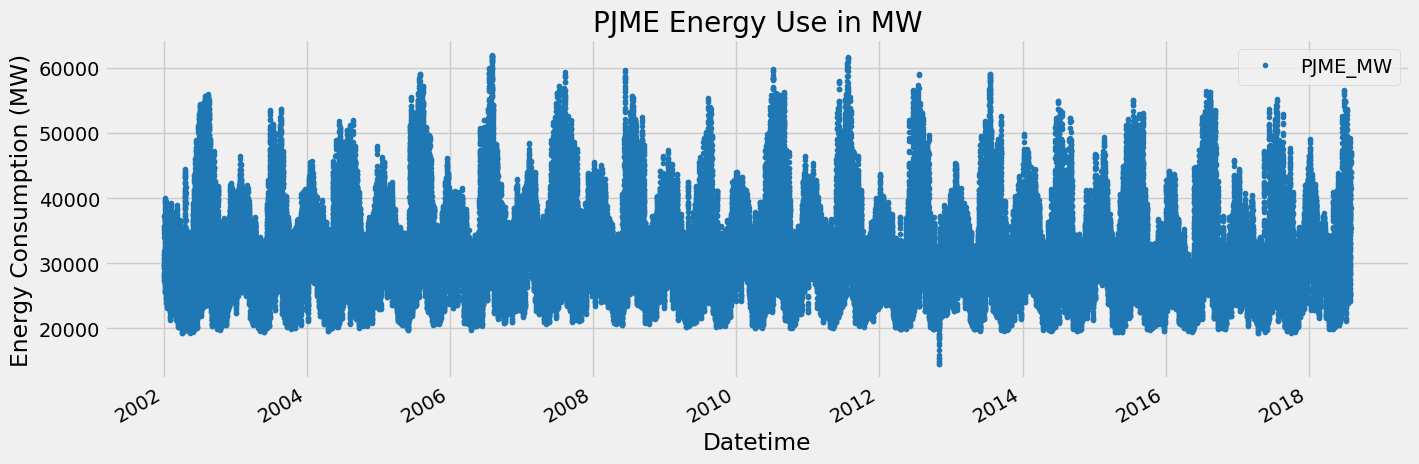

In [5]:
# Plotting the PJME energy
ax = df.plot(
    style=".",                    # Use dots to represent each data point on the plot
    figsize=(15, 5),              # Set the figure size to 15 inches wide by 5 inches tall
    color=color_pal[0],           # Use the first color from the color palette for the plot points
    title="PJME Energy Use in MW" # Set the title of the plot to indicate the data being displayed
)

# Add axis labels
ax.set_xlabel("Datetime")
ax.set_ylabel("Energy Consumption (MW)")

# Display the plot
plt.show()


## Data Quality Check: PJME Energy Consumption Plot

This plot visualizes PJME energy consumption over time to assess data quality and identify any issues that could affect model accuracy. By plotting the data, we can observe:

- **Trends**: Patterns in energy consumption over time, such as gradual increases or decreases.
- **Seasonality**: Repeating patterns at specific times, which may be due to seasonal demand fluctuations.
- **Outliers**: Data points that significantly deviate from typical energy consumption levels, potentially indicating anomalies or data errors.
- **Missing Data**: Any visible gaps in the time series, suggesting missing values that may need imputation.

This visual inspection helps confirm that the data is clean and reliable, ensuring a strong foundation for accurate modeling and prediction.


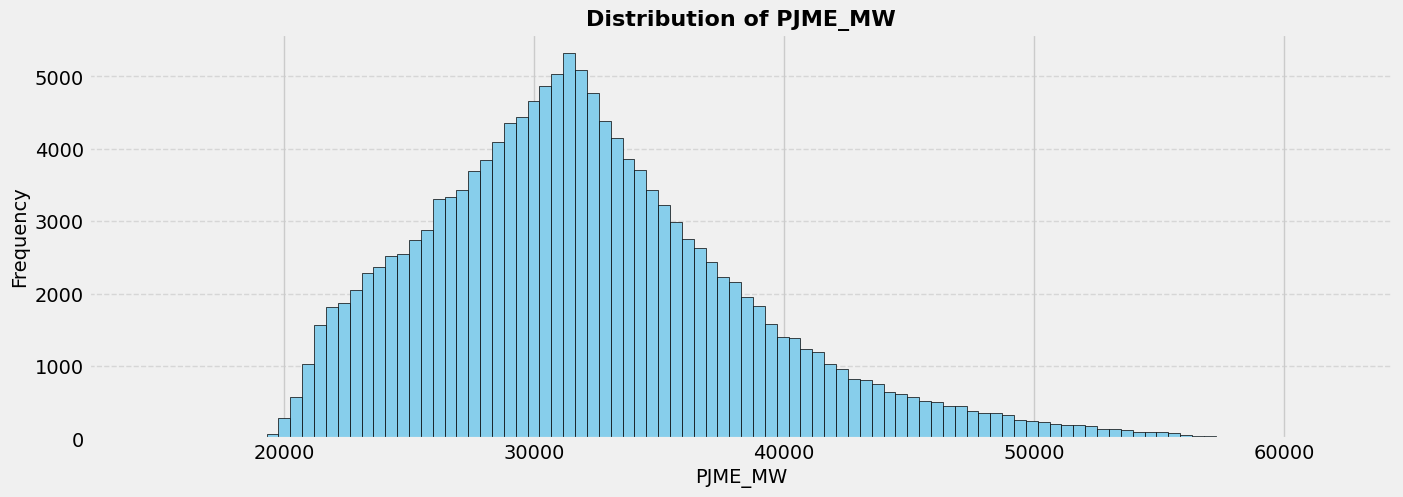

In [6]:
# Set up figure size and styling
plt.figure(figsize=(15, 5))
plt.hist(df['PJME_MW'], bins=100, color='skyblue', edgecolor='black')  # Reduced bins from 500 to 100 for thicker bars

# Add titles and labels
plt.title('Distribution of PJME_MW', fontsize=16, fontweight='bold')
plt.xlabel('PJME_MW', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


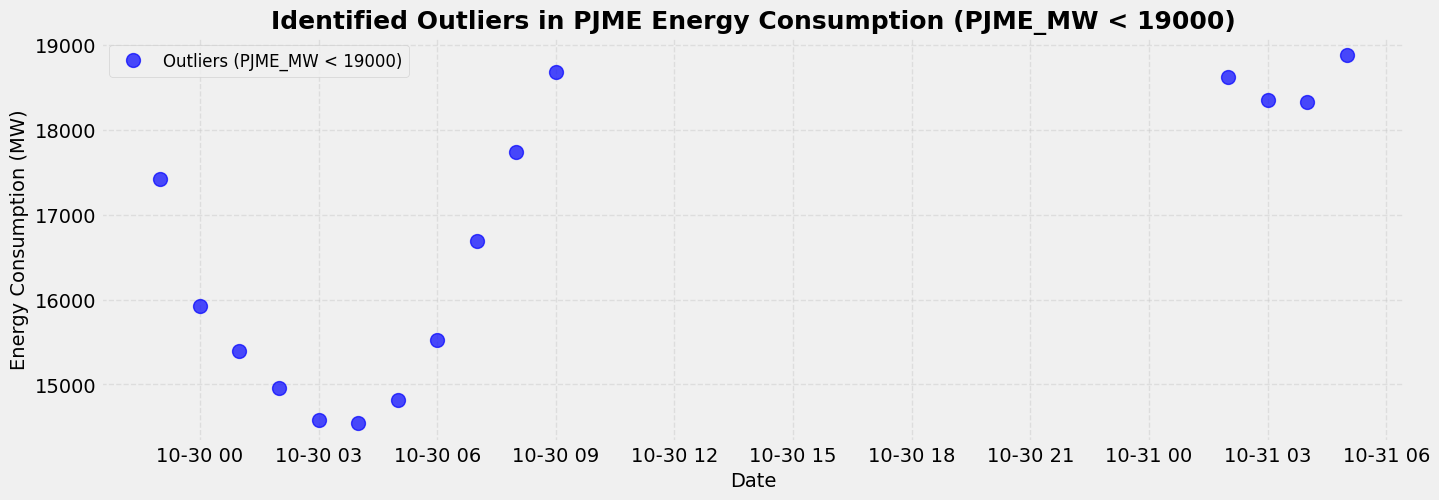

In [7]:
# Plot the outliers with enhanced styling
plt.figure(figsize=(15, 5))
plt.plot(df.query('PJME_MW < 19000').index, 
         df.query('PJME_MW < 19000')['PJME_MW'], 
         linestyle='None', marker='o', markersize=10, 
         color='blue', alpha=0.7, label='Outliers (PJME_MW < 19000)')

# Title and labels
plt.title('Identified Outliers in PJME Energy Consumption (PJME_MW < 19000)', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption (MW)', fontsize=14)

# Customize grid lines for readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend
plt.legend(fontsize=12)

# Display the plot
plt.show()


## Identifying and Investigating Outliers in PJME Energy Data

From the full PJME energy consumption plot, we can identify potential outliers—data points that fall significantly below typical levels. These unusually low values could be due to various reasons, such as:

- **Power Outages**: Unexpected events causing large-scale power interruptions.
- **Weather Conditions**: Instances of mild weather when energy demand is naturally lower.
- **Other Operational Issues**: Situations that temporarily reduce electricity demand or restrict usage.

Before removing these outliers, it's essential to investigate their causes to ensure we're not discarding valid and relevant data. Outliers may hold valuable information, especially if other features in the model capture relevant context (e.g., weather or operational conditions). Removing them without understanding the underlying reasons could lead to a loss of crucial information, potentially impacting the model's prediction accuracy.


In [8]:
# Remove rows where 'PJME_MW' is below 19,000
df = df.query('PJME_MW > 19000').copy()


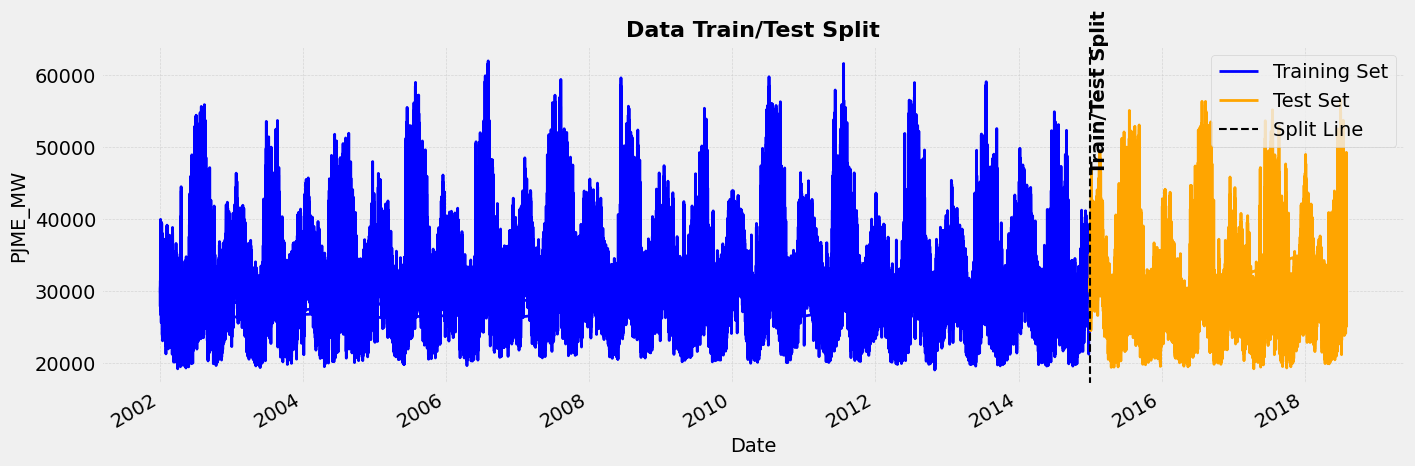

In [9]:
# Split the data into train and test sets
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Plot training and test sets with customized colors
train.plot(ax=ax, label='Training Set', color='blue', linewidth=2)
test.plot(ax=ax, label='Test Set', color='orange', linewidth=2)

# Add vertical line for split date with annotation
ax.axvline('2015-01-01', color='black', linestyle='--', linewidth=1.5)
ax.text('2015-01-01', ax.get_ylim()[1] * 0.9, 'Train/Test Split', 
        rotation=90, color='black', verticalalignment='center', fontweight='bold')

# Customize title and labels
ax.set_title('Data Train/Test Split', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('PJME_MW', fontsize=14)

# Display grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add legend and show plot
ax.legend(['Training Set', 'Test Set', 'Split Line'])
plt.show()


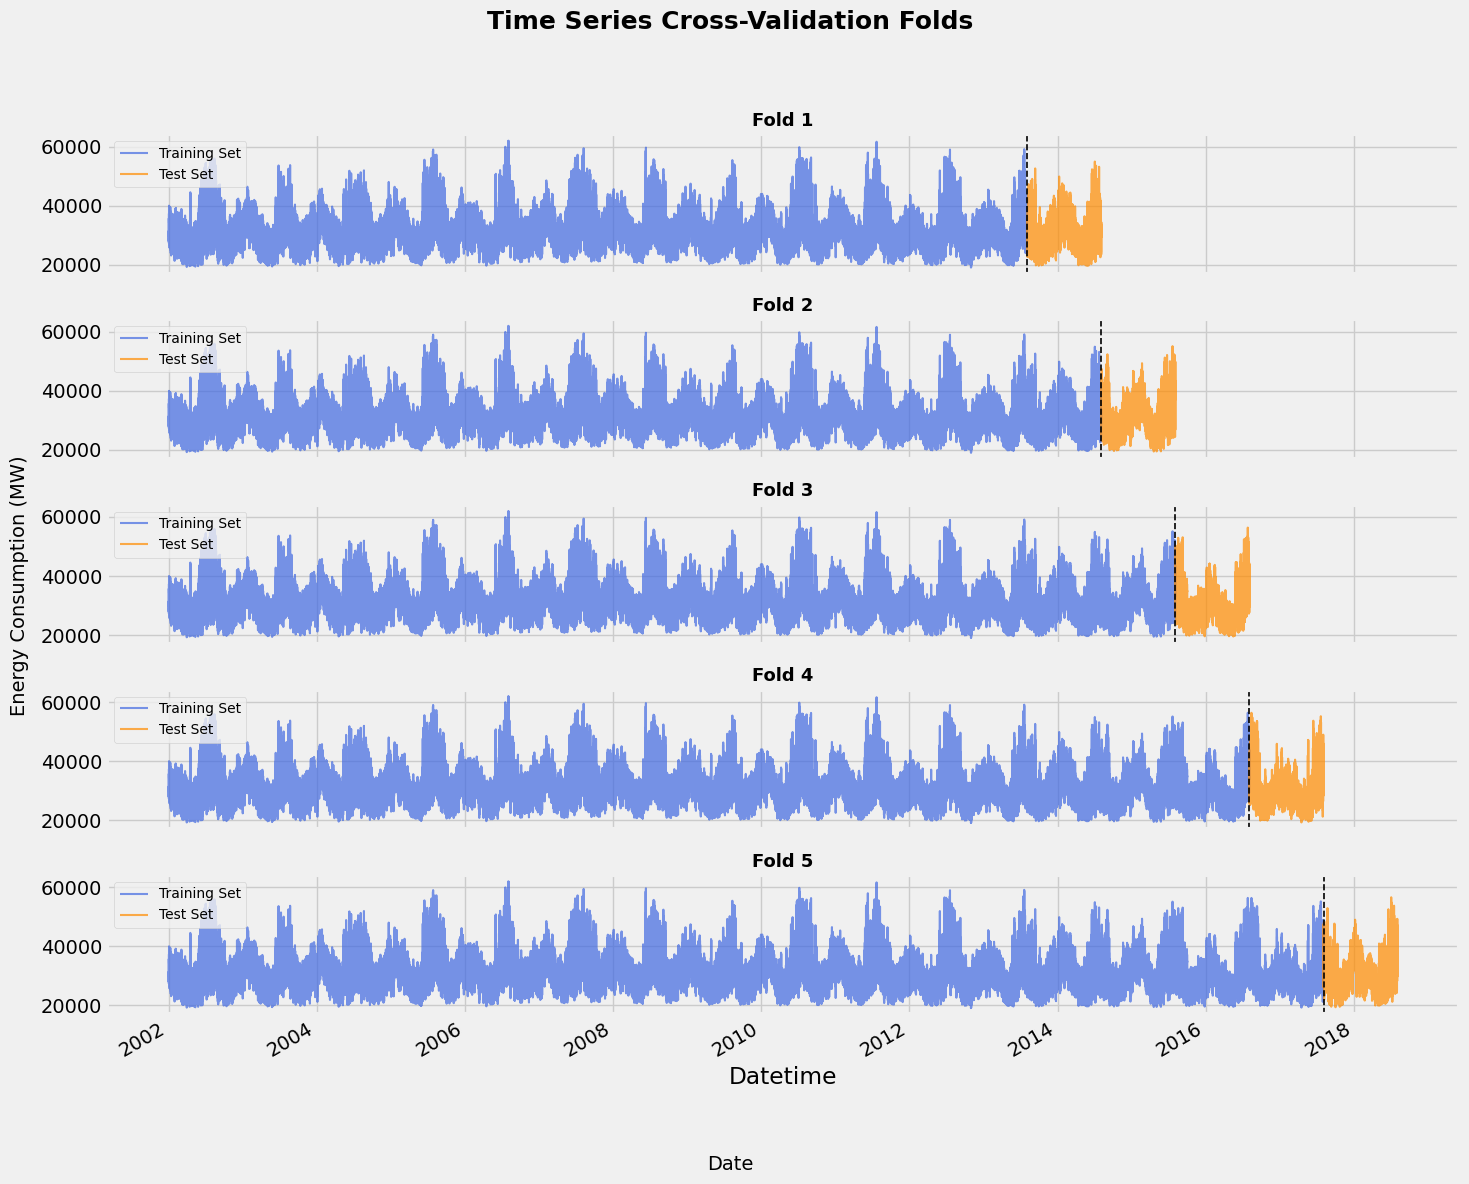

In [10]:
# Initialize TimeSeriesSplit with specified number of splits, test size, and gap
tss = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)
df = df.sort_index()  # Ensure data is sorted by date

# Set up the figure with shared x-axis for better comparison across folds
fig, axs = plt.subplots(tss.get_n_splits(), 1, figsize=(15, 12), sharex=True)

# Loop through each fold and plot the train/test split
for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    # Define training and test sets for the current fold
    train, test = df.iloc[train_idx], df.iloc[val_idx]

    # Plot the training set
    train['PJME_MW'].plot(ax=axs[fold], color='royalblue', alpha=0.7, linewidth=1.5, label='Training Set')
    # Plot the test set
    test['PJME_MW'].plot(ax=axs[fold], color='darkorange', alpha=0.7, linewidth=1.5, label='Test Set')
    
    # Add a vertical line to mark the start of the test set
    axs[fold].axvline(test.index.min(), color='black', linestyle='--', linewidth=1.2)
    axs[fold].set_title(f'Fold {fold + 1}', fontsize=13, fontweight='bold')
    axs[fold].legend(loc='upper left', fontsize=10)

# Add a main title and axis labels
fig.suptitle('Time Series Cross-Validation Folds', fontsize=18, fontweight='bold')
fig.supxlabel('Date', fontsize=14)
fig.supylabel('Energy Consumption (MW)', fontsize=14)

# Improve layout and spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Explanation of `create_features` Function

The `create_features` function enriches the dataset by extracting various time-based features from the datetime index of a DataFrame. These features help capture temporal patterns and seasonality in time series data, which can improve the performance of machine learning models for tasks like forecasting. Here’s a breakdown of each set of features created in the function:

### Basic Temporal Features
1. **Hour** (`df["hour"]`): Extracts the hour (0–23) from the datetime index. This feature is useful for identifying hourly patterns, such as peak and off-peak usage in energy consumption.
   
2. **Day of the Week** (`df["dayofweek"]`): Extracts the day of the week (0 for Monday to 6 for Sunday). This can capture weekly patterns, such as increased activity on weekends.

3. **Quarter** (`df["quarter"]`): Extracts the quarter of the year (1–4). This feature is beneficial when there are quarterly cycles or seasonal effects.

4. **Month** (`df["month"]`): Extracts the month (1–12), which can help capture monthly seasonality, such as higher energy use in winter or summer.

5. **Year** (`df["year"]`): Extracts the year, which is useful if there are long-term trends over multiple years.

6. **Day of the Year** (`df["dayofyear"]`): Extracts the day of the year (1–365 or 366 for leap years). This feature helps capture annual seasonality or trends.

### Additional Temporal Features
7. **Day of the Month** (`df["dayofmonth"]`): Extracts the day of the month (1–31), which can be helpful for monthly billing cycles or specific dates that impact activity.

8. **Week of the Year** (`df["weekofyear"]`): Extracts the ISO week number (1–52) of the year. This feature helps capture trends or seasonality at a weekly level.

9. **Is Weekend** (`df["is_weekend"]`): A binary feature that indicates if the day is a weekend (1 if Saturday or Sunday, otherwise 0). This is useful for distinguishing between weekday and weekend patterns.

10. **Is Month Start / End** (`df["is_month_start"]`, `df["is_month_end"]`): Binary features that indicate the start and end of a month. These are useful when activity spikes at the beginning or end of each month.

11. **Is Quarter Start / End** (`df["is_quarter_start"]`, `df["is_quarter_end"]`): Binary features that indicate the start and end of a quarter. Useful for quarterly patterns, such as business cycles.

12. **Is Year Start / End** (`df["is_year_start"]`, `df["is_year_end"]`): Binary features for the start and end of the year. These can capture changes in behavior that happen around the beginning or end of each year.

### Cyclical Features (Sine and Cosine Transformations)
Time-based features like `hour`, `day of the week`, and `month` have cyclical nature (e.g., after 23:00 comes 00:00). Using sine and cosine transformations allows machine learning models to recognize these cyclical patterns.

13. **Sine and Cosine of Hour** (`sin_hour`, `cos_hour`): These transformations capture the cyclical nature of hours (e.g., 23:00 to 00:00).

14. **Sine and Cosine of Day of the Week** (`sin_dayofweek`, `cos_dayofweek`): These transformations allow models to understand the cyclical nature of days in a week (e.g., Sunday to Monday).

15. **Sine and Cosine of Month** (`sin_month`, `cos_month`): These transformations capture the cyclical pattern of months (e.g., December to January).

### Purpose and Usefulness
Adding these features allows models to recognize patterns that repeat on a daily, weekly, monthly, or yearly basis, and it can improve the predictive power for time series data. For instance:
- **Cyclical transformations** allow models to interpret continuous cycles more effectively.
- **Binary indicators** for the start/end of months, quarters, and years provide insight into behavioral shifts that occur around these boundaries.
- **Hour and day of the week** features help capture daily and weekly seasonality, common in many time series data types.

This feature engineering approach can be especially valuable in forecasting tasks, where understanding the temporal structure of data is key to creating an effective predictive model.


In [11]:
def create_features(df):
    # Existing features
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    
    # Additional features
    df["dayofmonth"] = df.index.day              # Day of the month (1 to 31)
    df["weekofyear"] = df.index.isocalendar().week  # Week of the year (1 to 52)
    df["is_weekend"] = df.index.dayofweek >= 5    # Binary feature for weekends (1 if weekend, else 0)
    df["is_month_start"] = df.index.is_month_start # Binary feature for start of month
    df["is_month_end"] = df.index.is_month_end     # Binary feature for end of month
    df["is_quarter_start"] = df.index.is_quarter_start # Binary feature for start of quarter
    df["is_quarter_end"] = df.index.is_quarter_end     # Binary feature for end of quarter
    df["is_year_start"] = df.index.is_year_start   # Binary feature for start of year
    df["is_year_end"] = df.index.is_year_end       # Binary feature for end of year

    # Cyclical features (useful for capturing seasonality patterns)
    df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24)    # Sine transformation for hour
    df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24)    # Cosine transformation for hour
    df["sin_dayofweek"] = np.sin(2 * np.pi * df["dayofweek"] / 7)  # Sine transformation for day of the week
    df["cos_dayofweek"] = np.cos(2 * np.pi * df["dayofweek"] / 7)  # Cosine transformation for day of the week
    df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)  # Sine transformation for month
    df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)  # Cosine transformation for month
    
    return df

df = create_features(df)


## Explanation of `add_lags` Function

The `add_lags` function enhances the dataset by adding lagged features, capturing historical energy consumption values from approximately one, two, and three years ago. These lagged features help the model identify seasonal patterns, which can improve the accuracy of time series forecasting.

### How It Works

1. **Mapping Target Values**:
   The function first creates a dictionary that links each timestamp to its corresponding energy consumption value. This mapping enables quick lookup of past energy values based on specific dates.

2. **Creating Lagged Features**:
   Three new columns are added to the dataset:
   - `lag1`: Contains the energy consumption value from roughly one year ago (364 days).
   - `lag2`: Contains the energy consumption value from two years ago (728 days).
   - `lag3`: Contains the energy consumption value from three years ago (1092 days).
   
   Each of these lagged columns is generated by referencing the mapped historical values for each date in the dataset. By looking up energy values from previous years, the model can learn from patterns that repeat annually.

3. **Purpose of Lagged Features**:
   Including lagged features allows the model to capture recurring seasonal patterns, which are often critical in time series data. By learning from these historical trends, the model can make more informed and accurate forecasts for future energy consumption.


In [12]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)


## Code Explanation: Hyperparameter Optimization for Time Series Forecasting Model

This code performs hyperparameter optimization for a time series forecasting model using XGBoost and Optuna. The goal is to select the best parameters that minimize the model’s Root Mean Square Error (RMSE) on a cross-validated dataset, improving the model’s predictive accuracy.

### Steps and Key Components

1. **Define Features and Target**:
   - `FEATURES`: A list of variables used as input features for the model. It includes time-based features (e.g., `dayofyear`, `hour`), lagged values (`lag1`, `lag2`, `lag3`), binary indicators (e.g., `is_weekend`, `is_month_start`), and cyclical features (e.g., `sin_hour`, `cos_hour`) to capture patterns in the data.
   - `TARGET`: The variable we aim to predict, in this case, `PJME_MW`, which represents energy consumption.

2. **Set Up Cross-Validation**:
   - `TimeSeriesSplit`: A method for cross-validation tailored to time series data. It creates sequential train/test splits, ensuring that past data is used to predict future values. Here, it performs a 5-fold split with a test size of one year (`24*365`) and a gap of 24 hours between train and test sets to prevent data leakage.

3. **Define the Optuna Objective Function**:
   - `objective(trial)`: A function to test different model hyperparameters for each trial in the Optuna optimization process.
   - **Hyperparameters**: Suggested values for parameters like `n_estimators`, `max_depth`, `learning_rate`, `subsample`, etc., which control the complexity and learning behavior of the XGBoost model.
   - **XGBoost Regressor**: An XGBoost regression model is trained on each fold of the cross-validation split.
   - **RMSE Calculation**: For each trial, the model's RMSE is calculated on the validation set to assess performance. The average RMSE across all folds is returned as the objective value.

4. **Run the Optuna Study**:
   - `optuna.create_study(direction='minimize')`: Creates an Optuna study aimed at minimizing the RMSE.
   - `study.optimize(objective, n_trials=20)`: Runs the optimization process for 20 trials, each with different hyperparameter combinations.

5. **Output Best Parameters and RMSE**:
   - After the optimization, the best parameters (`best_params`) and the lowest cross-validated RMSE (`best_cv_rmse`) are retrieved and displayed.

### Purpose and Outcome

This code is designed to find the optimal XGBoost model configuration for time series forecasting. By using cross-validation and minimizing RMSE, the code ensures that the model generalizes well and provides accurate predictions on unseen data. The final output includes the best parameters and the lowest RMSE, giving an indication of the model’s predictive quality.


In [13]:
# Define features and target
FEATURES = [
    'dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 
    'lag1', 'lag2', 'lag3', 'dayofmonth', 'weekofyear', 'is_weekend', 
    'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 
    'is_year_start', 'is_year_end', 'sin_hour', 'cos_hour', 
    'sin_dayofweek', 'cos_dayofweek', 'sin_month', 'cos_month'
]
TARGET = 'PJME_MW'

# Define cross-validation with TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)

# Define Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',       # Use CPU-compatible histogram tree method
        'device': 'cuda',            # Specify CUDA for GPU acceleration
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'early_stopping_rounds': 50
    }
    
    # Cross-validation for each fold
    scores = []
    for train_idx, val_idx in tss.split(df):
        train, test = df.iloc[train_idx], df.iloc[val_idx]
        
        X_train, y_train = train[FEATURES], train[TARGET]
        X_test, y_test = test[FEATURES], test[TARGET]
        
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        
        y_pred = model.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
    
    return np.mean(scores)

# Run Optuna study and return only the final best parameters and RMSE score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Output the best parameters and the best CV RMSE score
best_params = study.best_params
best_cv_rmse = study.best_value

(best_params, best_cv_rmse)


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:38:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


({'n_estimators': 1738,
  'max_depth': 10,
  'learning_rate': 0.018985078938936122,
  'subsample': 0.5916236536343472,
  'colsample_bytree': 0.5082768535941514,
  'gamma': 0.05336012120866933,
  'lambda': 0.00033409349371221015},
 3637.9570763597794)

## Explanation of Model Parameters and Results

The model parameters listed here represent the configuration of an XGBoost regressor, optimized through a hyperparameter tuning process. Each parameter influences how the model learns and generalizes on the time series data, specifically for predicting energy consumption. 

### Key Parameters

- **`n_estimators`**: 1410  
  - The number of trees (estimators) in the model. Higher values allow the model to fit the data more closely but can lead to overfitting if too high.

- **`max_depth`**: 5  
  - The maximum depth of each tree. A depth of 5 allows the model to capture moderately complex patterns without excessive overfitting.

- **`learning_rate`**: 0.0134  
  - Controls the step size for updating weights in each boosting round. A lower learning rate (0.0134) slows down the learning process, which often results in better generalization, especially with a higher number of estimators.

- **`subsample`**: 0.5063  
  - The fraction of samples used to build each tree. A value of 0.5063 means that each tree is built using about 50% of the data, helping to reduce overfitting.

- **`colsample_bytree`**: 0.5764  
  - The fraction of features (columns) considered when building each tree. Here, 57.64% of the features are randomly selected for each tree, which promotes model diversity and reduces overfitting.

- **`gamma`**: 0.0011  
  - The minimum loss reduction required to make a further partition on a leaf node. A low gamma value (0.0011) allows more splits, which can capture more intricate patterns.

- **`lambda`**: 0.00038  
  - L2 regularization term on weights, which helps prevent overfitting by penalizing larger weights. A small value (0.00038) indicates minimal regularization, suggesting the model might not need strong regularization.

### Model Performance

- **RMSE (Root Mean Square Error)**: 3640.70  
  - This value is the average RMSE obtained from cross-validation. It measures the model’s prediction accuracy in terms of energy consumption, with lower values indicating better performance. An RMSE of 3640.70 means that, on average, the model’s predictions deviate by this amount from actual values.

These parameters were selected as optimal based on a tuning process, balancing complexity with generalization to improve the model's predictive accuracy on unseen data.


In [14]:
# Retrieve the best parameters from the Optuna study
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)

# Train on the full dataset
X_all, y_all = df[FEATURES], df[TARGET]
best_model.fit(X_all, y_all)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5082768535941514, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.05336012120866933,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.00033409349371221015,
             learning_rate=0.018985078938936122, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1738, n_jobs=None,
             num_parallel_tree=None, ...)

## Explanation of `make_future_predictions` Function

The `make_future_predictions` function is designed to forecast energy consumption for a specified number of years into the future, using a pre-trained machine learning model. It generates future dates, applies feature engineering, and outputs predictions on these new dates. Finally, it visualizes the predictions over the chosen time horizon.

### Key Steps and Importance

1. **Generate Future Dates**:
   - The function starts by creating a range of future dates based on the number of years ahead specified. It generates dates at the end of each month (`freq='ME'`), which helps maintain a consistent time interval for long-term forecasting.
   
2. **Feature Engineering on Future Data**:
   - The same feature engineering used during model training is applied to these new future dates, ensuring that the model receives inputs similar in structure to the training data. This includes cyclical and time-based features like month, day of the week, and year, which help capture seasonal patterns.

3. **Lagged Features Placeholders**:
   - Placeholder columns for lagged features (e.g., energy consumption from previous months) are added to ensure compatibility with the model’s expected input structure. Although these placeholders cannot capture actual lagged values (since future values are unknown), they help the model maintain the same input format.

4. **Prediction Generation**:
   - Using the provided model, predictions are generated for the future dates. The output is a column of predicted energy consumption values, allowing for a clear view of expected demand over the specified forecast horizon.

5. **Visualization of Predictions**:
   - The predictions are visualized in a plot, showing the forecasted energy consumption trajectory over time. Additional details, such as data point annotations and axis padding, improve readability and provide insight into the model’s long-term forecasts.

### Why This is Important

This function is essential for understanding the model’s performance on future, unseen data. By forecasting years ahead, it allows stakeholders to:

- **Anticipate Energy Demand**: Provides an estimate of future energy consumption, which is valuable for grid management, capacity planning, and resource allocation.
- **Observe Seasonal Trends**: The time-based features enable the model to account for seasonality in predictions, aiding in decision-making around peak demand times.
- **Validate Model Generalization**: By applying the model to future dates, we can assess its ability to generalize beyond the training data, an essential aspect for any robust forecasting model.

The ability to predict and visualize future energy consumption trends supports effective planning and highlights the impact of the model’s forecasting capabilities.


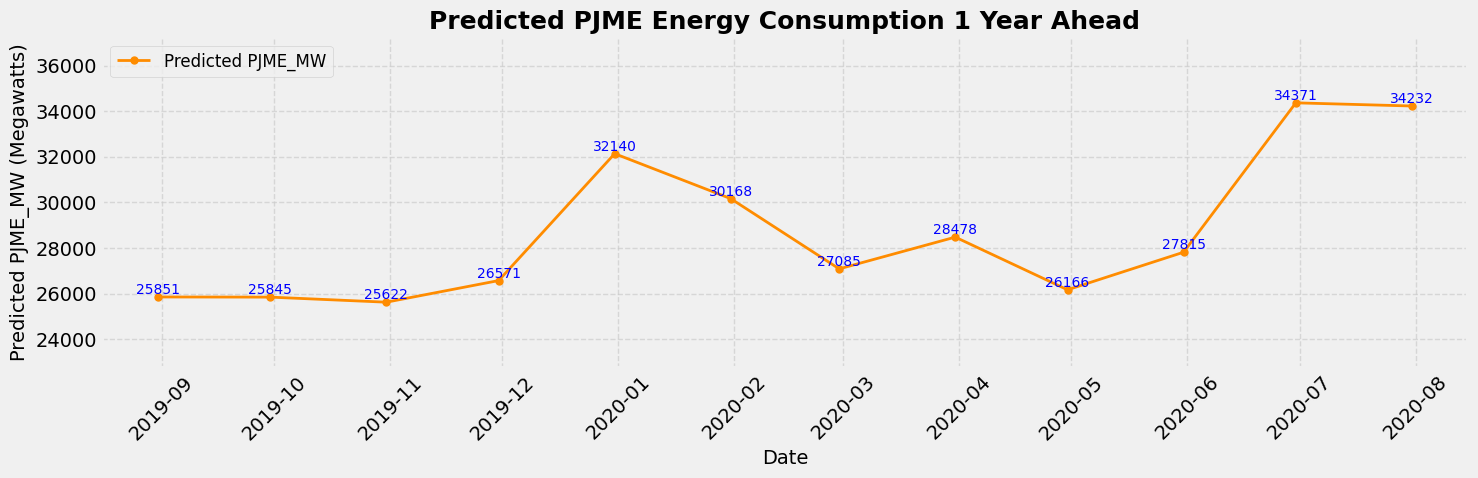

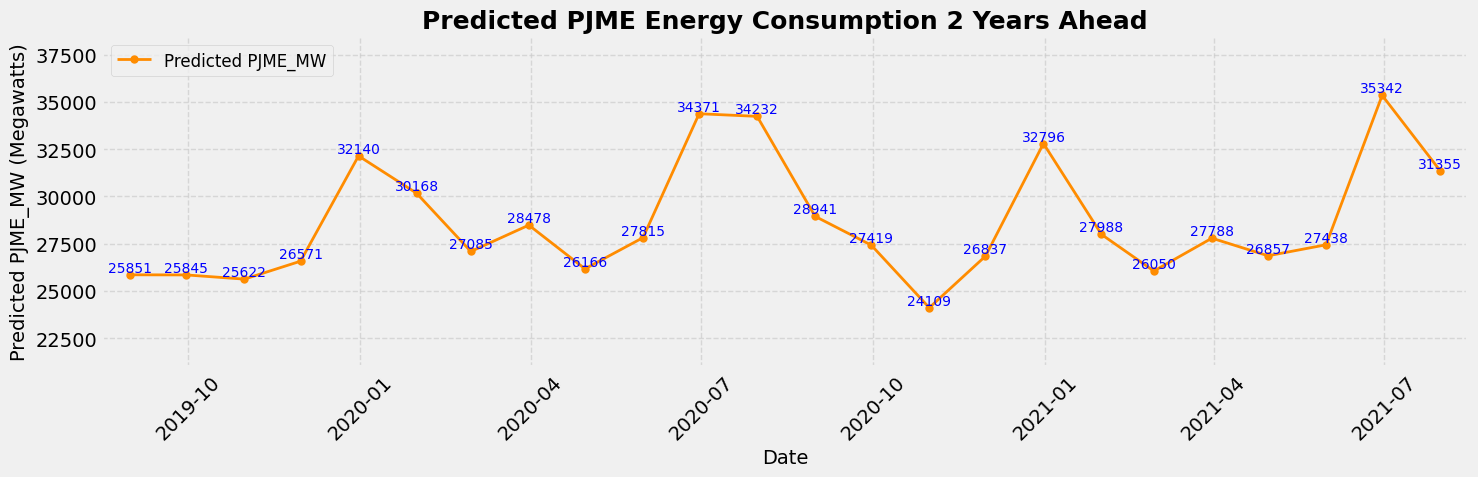

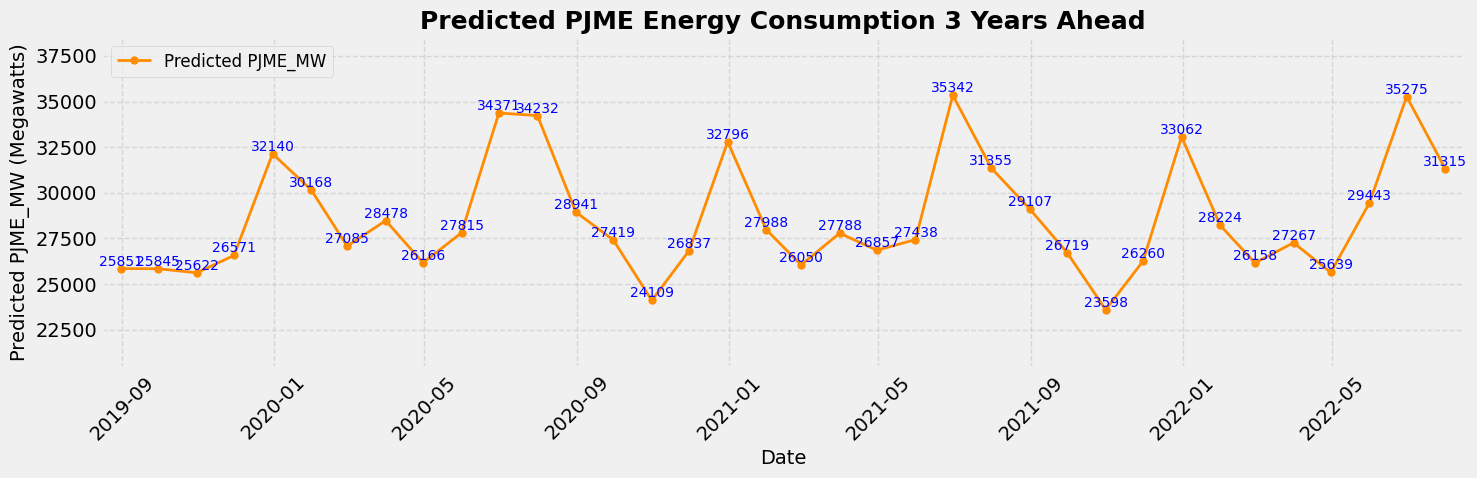

In [15]:
# Function to create future predictions for a specified number of years
def make_future_predictions(years_ahead, model, df, features, title_suffix):
    # Define the range of future dates based on the number of years ahead
    future_dates = pd.date_range(df.index.max() + pd.DateOffset(years=1), 
                                 periods=12 * years_ahead, freq='ME')  # Use 'ME' for month-end frequency
    future_df = pd.DataFrame(index=future_dates)

    # Apply feature engineering to the future dates
    future_df = create_features(future_df)

    # Add placeholder lag columns for compatibility
    for lag in [12, 24, 36]:  # Example lags in months
        lag_col = f'lag_{lag}_months'
        future_df[lag_col] = np.nan  # Placeholder for lags

    # Ensure all features are present in the future DataFrame
    missing_features = [feature for feature in features if feature not in future_df.columns]
    for feature in missing_features:
        future_df[feature] = np.nan

    # Make predictions
    future_df['predictions'] = model.predict(future_df[features])

    # Plot predictions
    plt.figure(figsize=(15, 5))
    plt.plot(future_df.index, future_df['predictions'], marker='o', linestyle='-', 
             color='darkorange', linewidth=2, markersize=5)
    plt.title(f'Predicted PJME Energy Consumption {title_suffix} Ahead', fontsize=18, fontweight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Predicted PJME_MW (Megawatts)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)

    # Adjust the x-axis to add padding on both ends
    start, end = future_df.index.min(), future_df.index.max()
    plt.xlim(start - pd.Timedelta(days=15), end + pd.Timedelta(days=15))  # Adds 15 days padding on both sides

    # Adjust the y-axis to add padding on top and bottom
    y_min, y_max = future_df['predictions'].min(), future_df['predictions'].max()
    y_padding = (y_max - y_min) * 0.1  # Add 10% padding
    plt.ylim(y_min - y_padding - 2000, y_max + y_padding + 2000)

    # Annotate each predicted point
    for date, pred in future_df['predictions'].items():
        plt.text(date, pred, f"{pred:.0f}", ha='center', va='bottom', fontsize=10, color='blue')

    plt.legend(['Predicted PJME_MW'], loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function for 1, 2, and 3 years ahead
make_future_predictions(1, best_model, df, FEATURES, '1 Year')
make_future_predictions(2, best_model, df, FEATURES, '2 Years')
make_future_predictions(3, best_model, df, FEATURES, '3 Years')
